# Como funciona um Projeto de Ciência de Dados na prática

São várias etapas importantes, de forma bem completa:

1. Entendimento do Desafio que você quer resolver
2. Entendimento da empresa/área
3. Extração/Obtenção de dados
4. Ajustes de dados (Limpeza de dados)
5. Análise exploratória
6. Modelagem + Algoritmos
7. Interpretação dos resultados
8. Deploy/Produção

### Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns

#### **Contexto**

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, etc) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo).

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

#### **Nosso Objetivo**

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajuda a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

#### **O que temos disponível, inspirações e créditos**

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontra resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também diferenças significativas no processo de construção do projeto:

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês;
- Os preços são dados em reais (R$);
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados.

#### **Expectativas Iniciais**

- Acredito que sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ;
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos);
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro.

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são exatamente importantes.

### 1 - Importar bibliotecas e base de dados

In [72]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Métricas para avaliação do modelo
from sklearn.metrics import r2_score, mean_squared_error

# Modelos de previsão
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Método para separar, treinar e testar os dados para o modelo
from sklearn.model_selection import train_test_split

In [73]:
# Capturando a pasta com os arquivos no meu computador
caminho_bases = pathlib.Path(r'Arquivos da Análise\dataset')

# Criando um dataframe vazio para que eu possa adicionar as outras bases e, assim, ter um dataframe apenas, com todas as bases
base_airbnb = pd.DataFrame()

# Vai ajudar a criar as colunas com o nome do mês e o ano
meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

# Capturando arquivos um por um
for arquivo in caminho_bases.iterdir():
    
    if 'Novo Dataset' not in arquivo.name:
        # Capturando o nome do mês e o ano dos arquivos
        nome_mes = arquivo.name[:3]
        num_mes = meses[nome_mes]
        
        ano = arquivo.name[-8:]
        ano = int(ano.replace('.csv', ''))
        
        # Adicionando todas as bases ao mesmo dataframe
        df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
        df['ano'] = ano
        df['mes'] = num_mes
        base_airbnb = base_airbnb.append(df)

display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


### 2 - Consolidar bases de dados

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:

  1. ID's, links e informações não relevantes para o modelo
  2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês)
  3. Colunas preenchidas com texto livre, não rodaremos nenhuma análise de palavras ou algo do tipo
  4. Colunas em que todos ou quase todos os valores são iguais

Para isso, vamos criar um arquivo excel com os 1.000 primeiros registros e fazer uma análise qualitativa

In [74]:
# Criar um arquivo excel com as 1000 primeiras linhas
base_airbnb.head(1000).to_csv(r'Arquivos da Análise\dataset\Novo Dataset\Primeiros_registros.csv', index=False)
print('Base criada com sucesso!')

Base criada com sucesso!


Após criar o dataset, foi feita uma análise qualitativa das features dos mesmos e chegamos a uma lista de features que foi utilizada na célula abaixo.

### 3 - Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas

In [75]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### 4 - Tratar valores ausentes

- Visualizando os dados, percebemos que existe uma grande disparidade em dados ausentes. As colunas com mais de 300.000 valores NaN foram excluídas da análise.
- Para outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [76]:
# print(base_airbnb.isnull().sum())

for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
        
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [77]:
base_airbnb.dropna(inplace=True)
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### 5 - Verificar tipos de dados em cada coluna

In [78]:
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


In [79]:
print(base_airbnb.iloc[0])

host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

Como preço e extra people estão sendo reconhecidos como objeto (ao invés de um float) temos que mudar o tipo de variável da coluna.

In [80]:
# price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# Extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

### Resumo das informações

Após tratar nossa base, nós retiramos mais colunas ainda e ficamos com menos colunas que achávamos que iríamos precisar. Segue explicação de cada feature:

- host_is_superhost: t para True e f para False. Se o anfitrião é um super usuário do site, ou seja, se tem credibilidade;
- host_listings_count: Quantidade de empreendimentos que o anfitrião tem;
- Latitude: Coordenada de localização;
- Longitude: Coordenada de localização;
- Property_type: Tipo de propriedade;
- Room_type: Descrição detalhada do empreendimento;
- Accommodates: Máximo de pessoas que cabem no empreendimento;
- Bathrooms: Quantidade de banheiros;
- Bedrooms: Quantidade de quartos;
- Beds: Quantidade de camas;
- Bed_type: Tipo da cama;
- Amenities: Lista de coisas/comodidades que o empreendimento possui;
- Price: Preço (R$);
- Guests_included: Quantidade de convidados incluídos;
- Extra_people: Preço adicional por pessoa, não acordado previamente;
- Minimum_nights: Mínimo de noites;
- Maximum_nights: Máximo de noites;
- Number_of_reviews: Número de avaliações que o empreendimento obteve;
- Instant bookable: Se está disponível para reserva;
- Is_business_travel_ready: Se é adaptado para uma viagem de negócios;
- Cancellation_policy: Política de cancelamento;
- Ano: Ano;
- Mês: Mês.

### 6 - Análise exploratória e tratar outliers

- Vamos basicamente olhar feature por feature para:
    
    1 - Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    
    2 - Excluir outliers(usaremos como regra, valores abaixo de Q1 - 1.5x Amplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    
    3 - Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.
- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, bathrooms, etc).
- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.


MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança aí. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo.

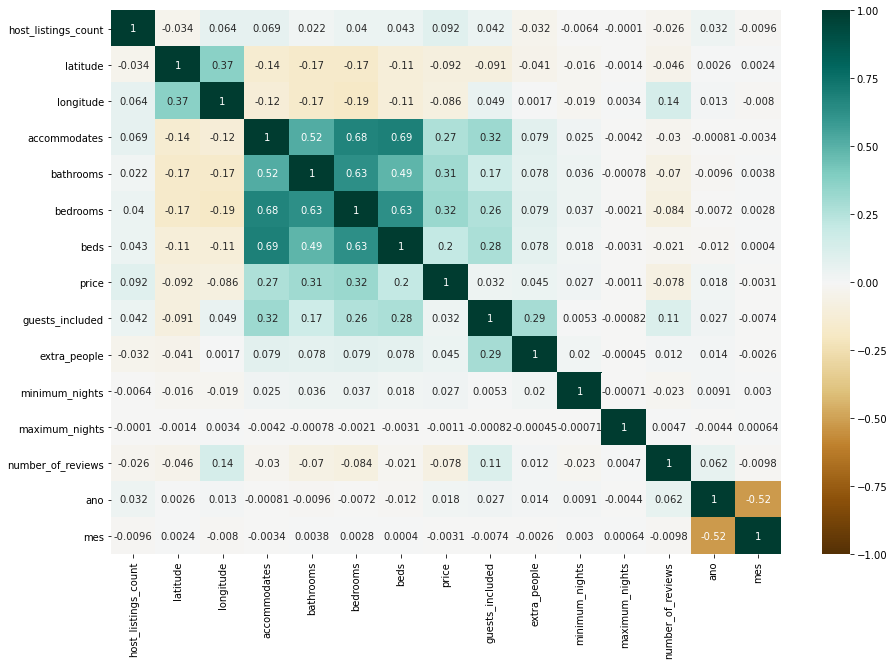

In [81]:
plt.figure(figsize=(15, 10))

sns.heatmap(base_airbnb.corr(), annot=True, cmap='BrBG', vmin=-1, vmax=1)
plt.show()

### Definição de funções para Análise de Outliers

Vamos definir algumas funções para ajudar a análise de outliers das colunas

In [82]:
# Definir um limite superior e inferior para a base
def limites(df, coluna):
    q1 = df[coluna].quantile(0.25)
    q3 = df[coluna].quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5*amplitude, q3 + 1.5*amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas =df.shape[0]
    lim_inf, lim_sup = limites(df, nome_coluna)
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    return df, qtde_linhas - df.shape[0]

In [91]:
# Plotar gráficos boxplot
def diagrama_caixa(df, coluna):
    # Definindo o tamanho dos dois gráficos
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)
    sns.boxplot(x=df[coluna], ax=ax1)
    ax1.set_title(f'{coluna} Diagrama de Caixa')
    
    # Setando os limites no eixo x
    ax2.set_xlim(limites(df, coluna))
    sns.boxplot(x=df[coluna], ax=ax2)
    ax2.set_title(f'Zoom nos limites de {coluna}')

# Plotar um histograma com curva KDE
def histograma(df, coluna):
    plt.figure(figsize=(20,5))
    ax = sns.distplot(df[coluna], norm_hist=True)
    ax.set_title(f'Distribuição {coluna}')


# Plotar um gráfico de barras
def grafico_barra(df, coluna):
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=df[coluna].value_counts().index, y=df[coluna].value_counts())
    ax.set_xlim(limites(df, coluna))

### price

c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



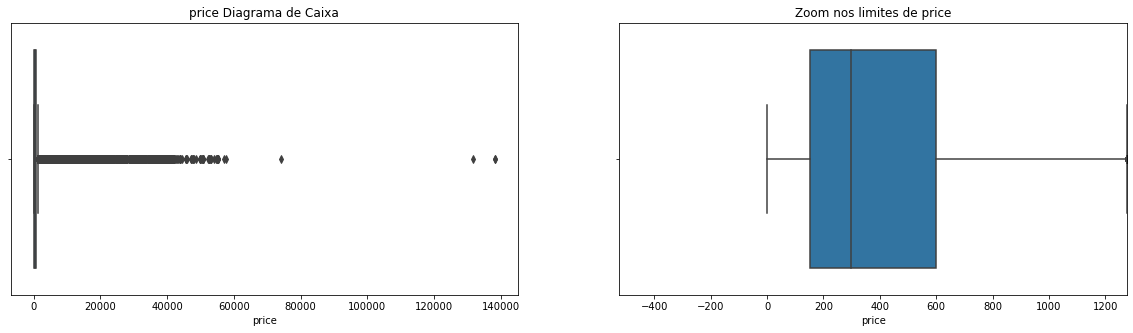

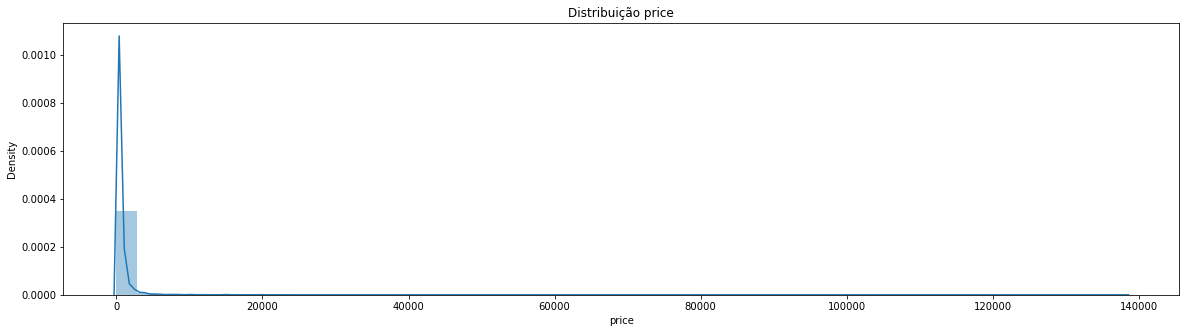

In [84]:
diagrama_caixa(base_airbnb, 'price')
histograma(base_airbnb, 'price')

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de imóveis de altíssimo luxo, que não é o nosso objetivo principal. Por isso podemos excluir esses outliers.

In [85]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'price')
print(f'{qtde_linhas:,} linhas removidas')

87,282 linhas removidas


c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



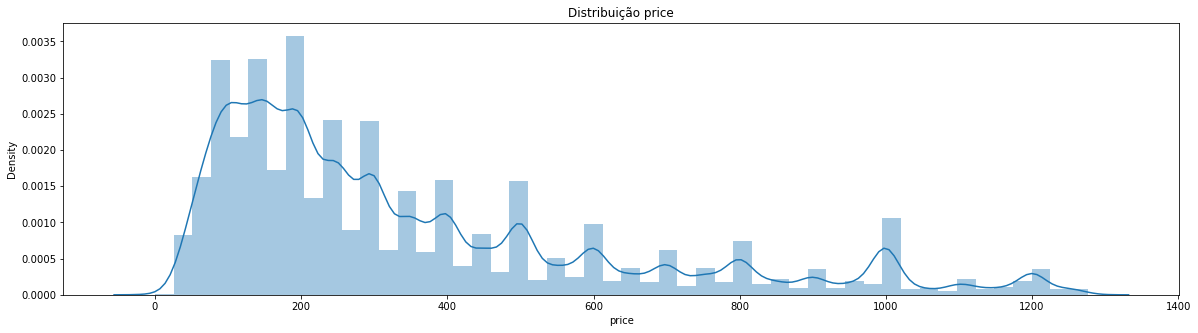

In [86]:
histograma(base_airbnb, 'price')

A probabilidade de valores "redondos" serem selecionados é maior, de acordo com o gráfico.

### Extra_people

c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



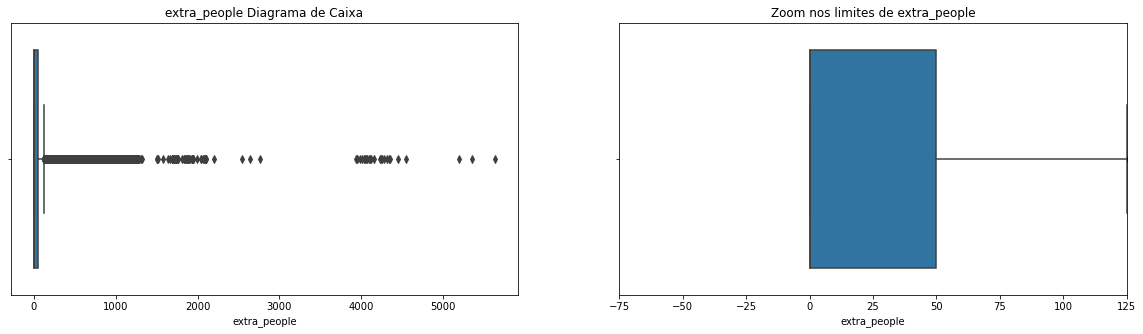

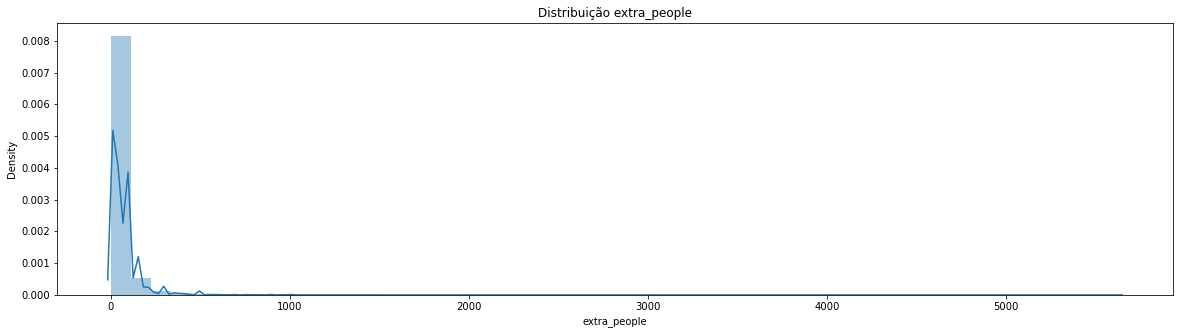

In [87]:
diagrama_caixa(base_airbnb, 'extra_people')
histograma(base_airbnb, 'extra_people')

In [88]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{qtde_linhas:,} linhas removidas')

59,194 linhas removidas


c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



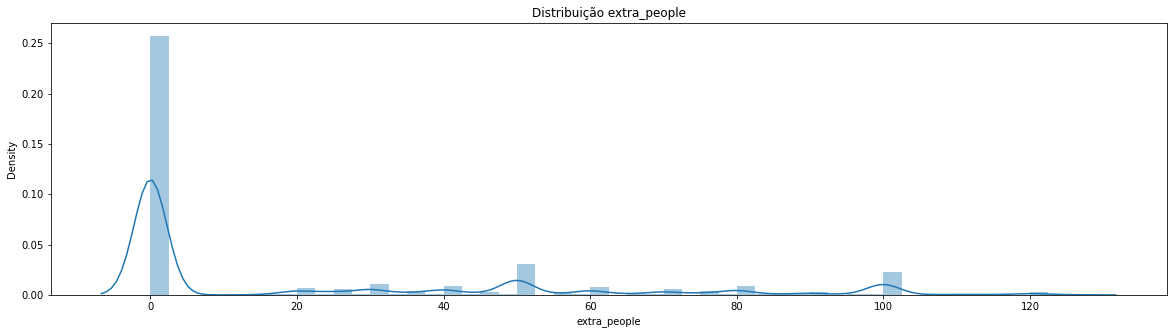

In [89]:
histograma(base_airbnb, 'extra_people')

### Host_listings_counts

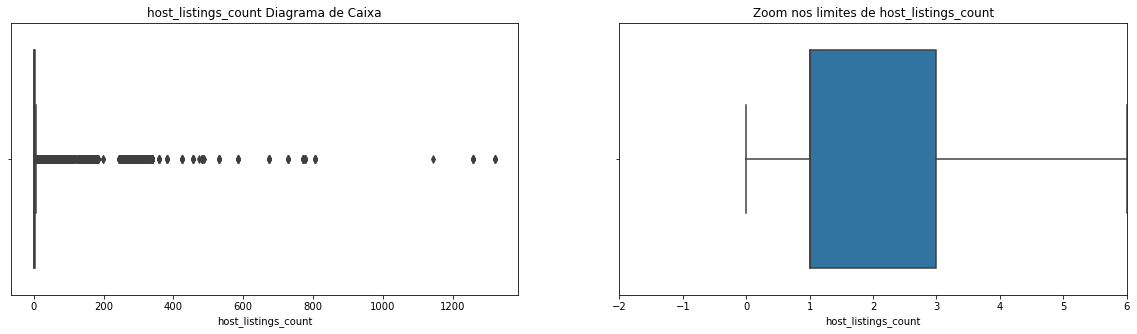

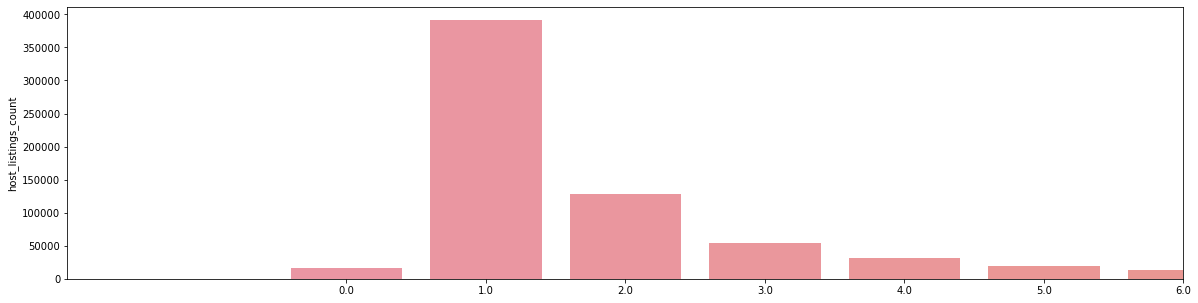

In [92]:
diagrama_caixa(base_airbnb, 'host_listings_count')
grafico_barra(base_airbnb, 'host_listings_count')

Podemos excluir os outliers, porque para o objetivo do nosso projeto os hosts com mais de 6 imóveis no airbnb não são público alvo do objetivo do projeto (imagino que são imobiliárias ou profissionais que gerenciam imóveis no airbnb)

In [93]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{qtde_linhas:,} linhas removidas')

97,723 linhas removidas


### Accommodates

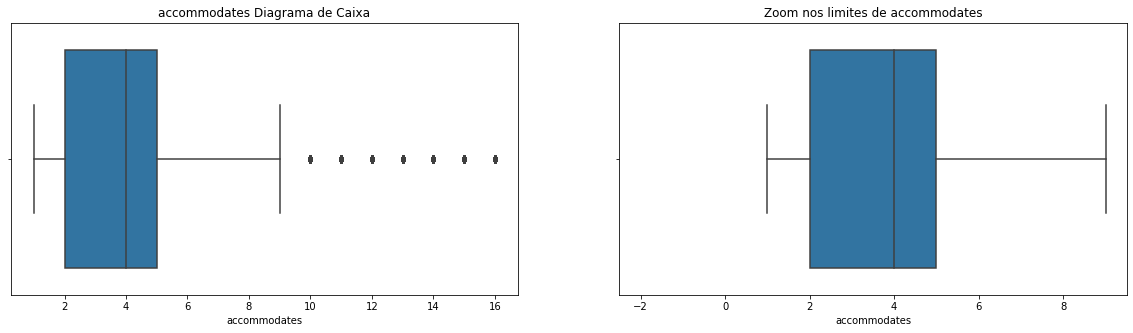

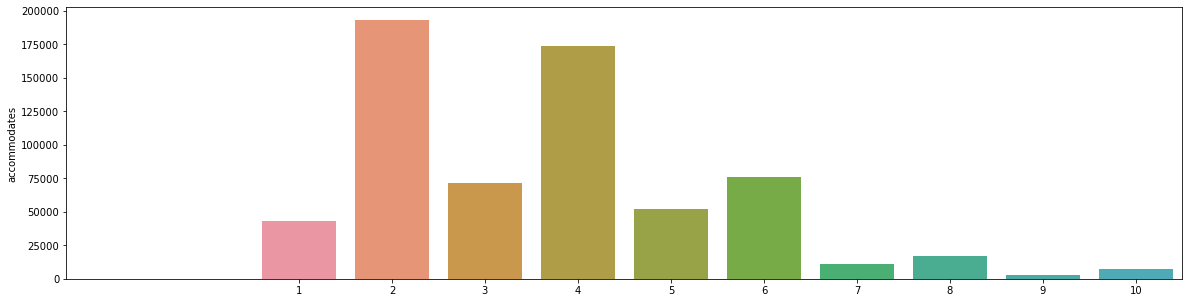

In [95]:
diagrama_caixa(base_airbnb, 'accommodates')
grafico_barra(base_airbnb, 'accommodates')

In [96]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{qtde_linhas:,} linhas removidas')

13,146 linhas removidas


### bathrooms

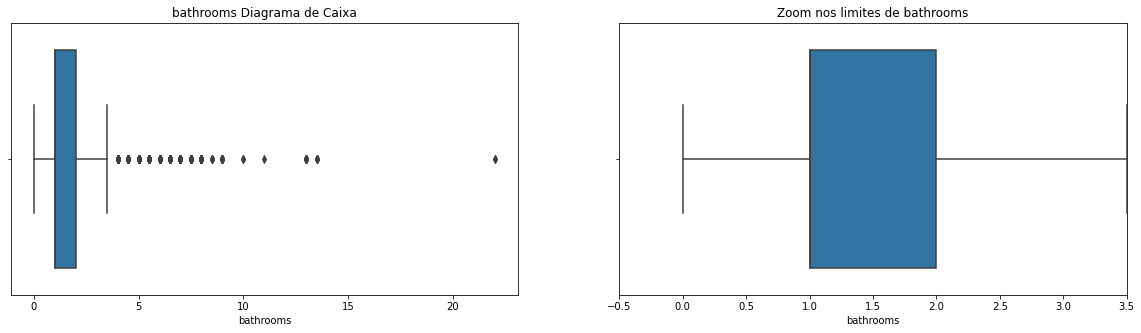

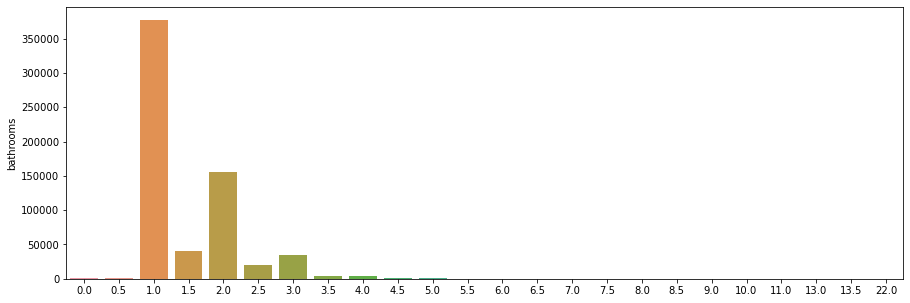

In [98]:
diagrama_caixa(base_airbnb, 'bathrooms')
plt.figure(figsize=(15,5))
ax = sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())
plt.show()

In [99]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{qtde_linhas:,} linhas removidas')

6,894 linhas removidas


### Bedrooms

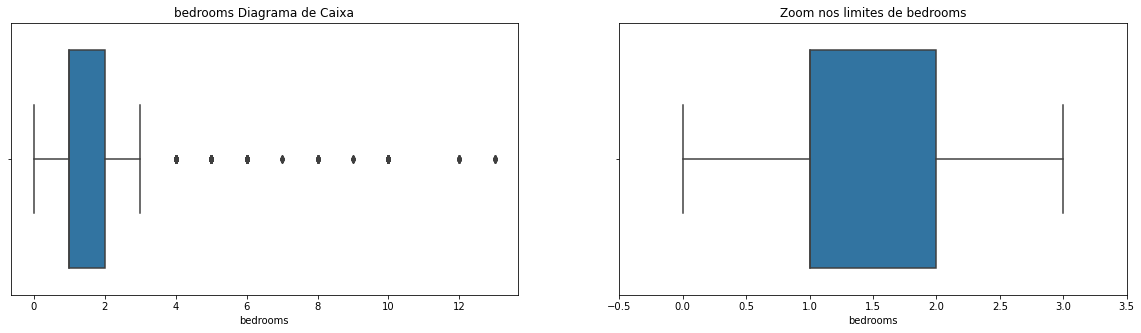

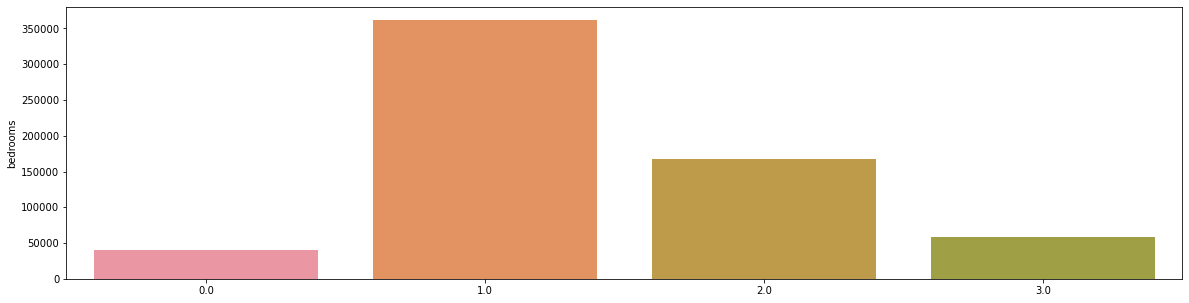

In [100]:
diagrama_caixa(base_airbnb, 'bedrooms')
grafico_barra(base_airbnb, 'bedrooms')

In [101]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{qtde_linhas:,} linhas removidas')

5,482 linhas removidas


### Beds

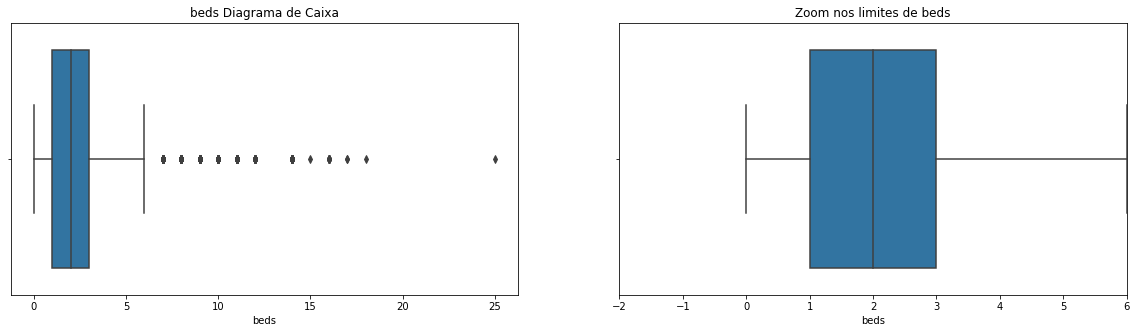

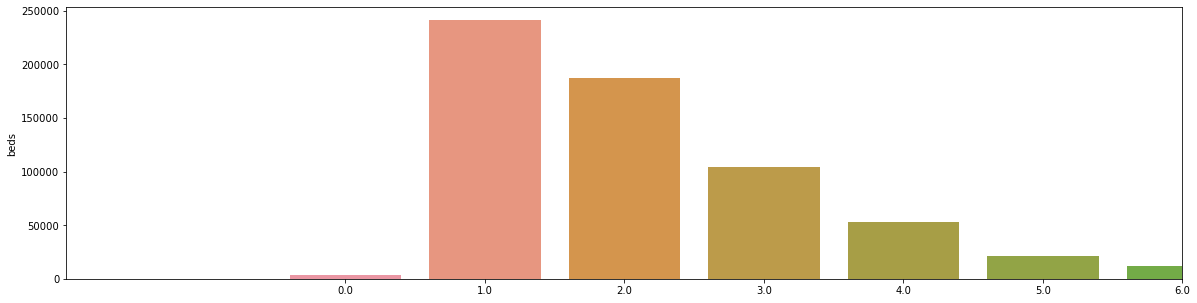

In [102]:
diagrama_caixa(base_airbnb, 'beds')
grafico_barra(base_airbnb, 'beds')

In [103]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{qtde_linhas:,} linhas removidas')

0 linhas removidas


### guests_included

<ipython-input-91-825b150df403>:10: UserWarning:

Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.

<ipython-input-91-825b150df403>:25: UserWarning:

Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.



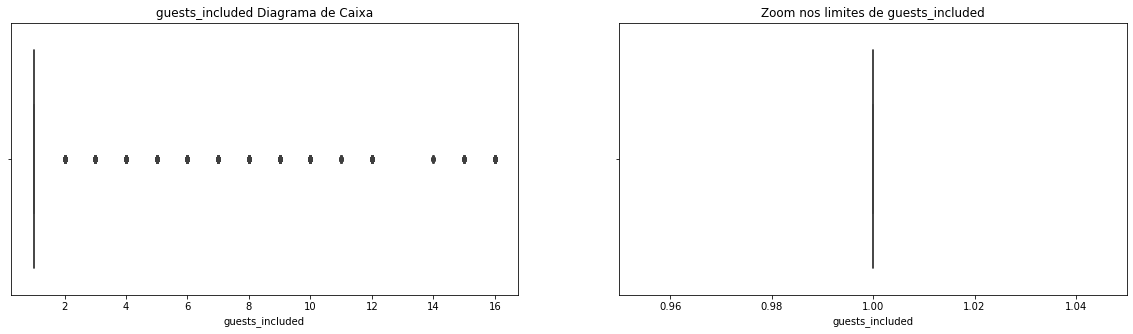

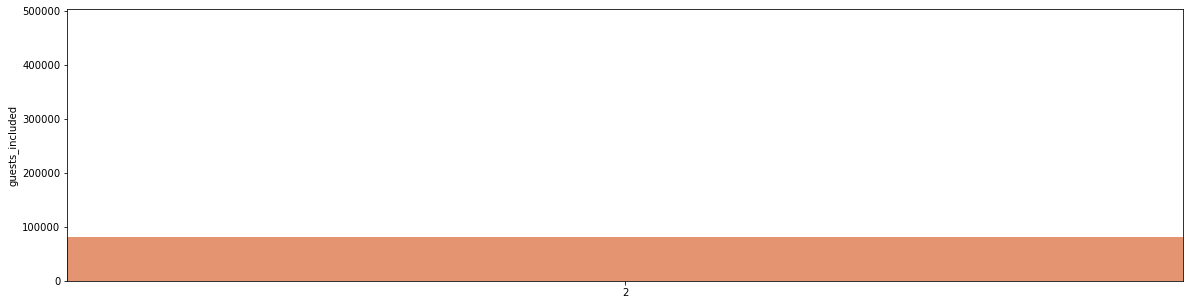

In [104]:
diagrama_caixa(base_airbnb, 'guests_included')
grafico_barra(base_airbnb, 'guests_included')

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guests_included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [105]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
# base_airbnb.shape
print(f'{qtde_linhas:,} linhas removidas')

0 linhas removidas


### minimum_nights

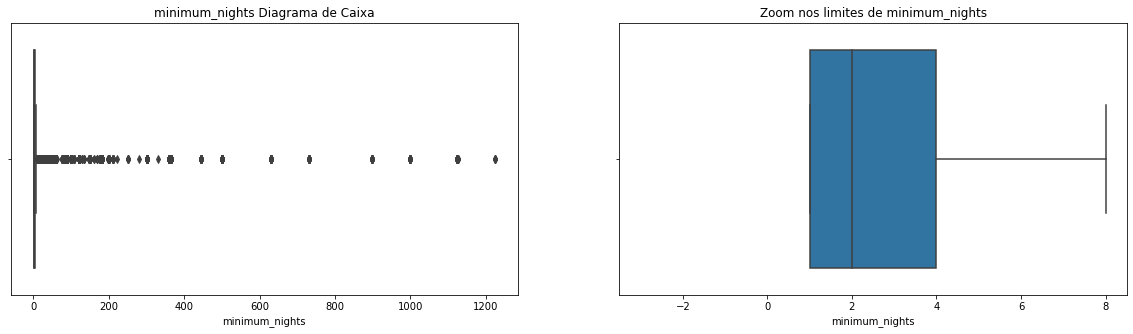

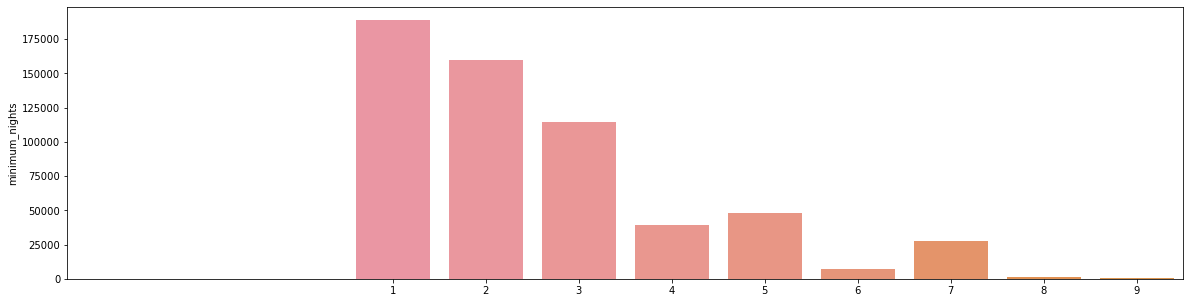

In [107]:
diagrama_caixa(base_airbnb,'minimum_nights')
grafico_barra(base_airbnb,'minimum_nights')

In [108]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{qtde_linhas:,} linhas removidas')

40,747 linhas removidas


### maximum_nights

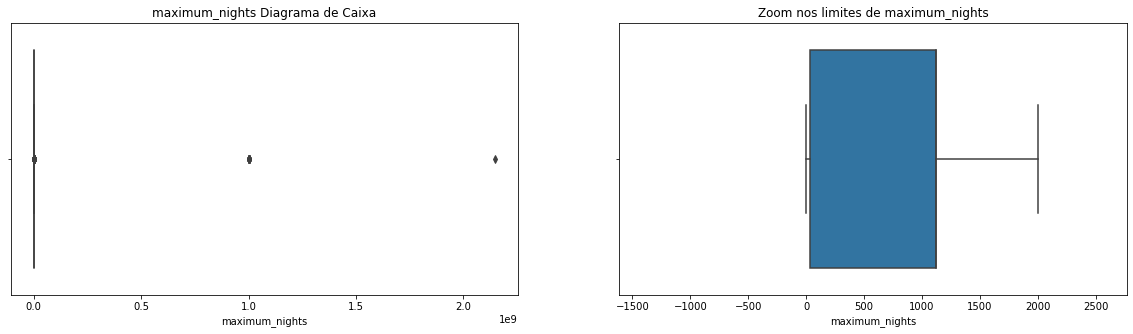

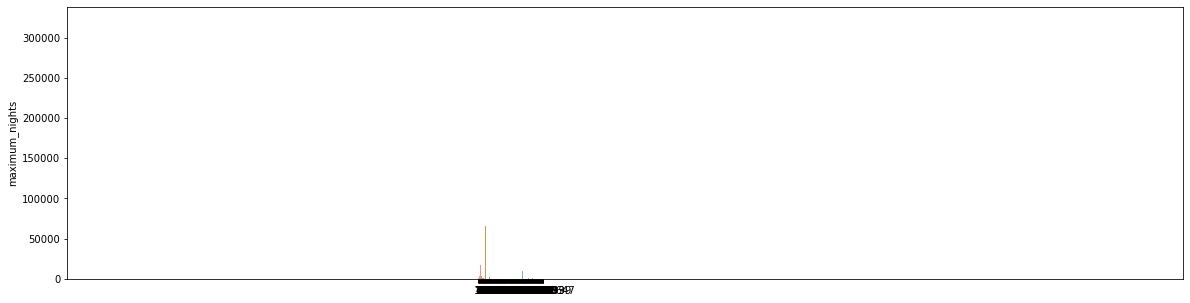

In [109]:
diagrama_caixa(base_airbnb, 'maximum_nights')
grafico_barra(base_airbnb, 'maximum_nights')

In [110]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

### number_of_reviews

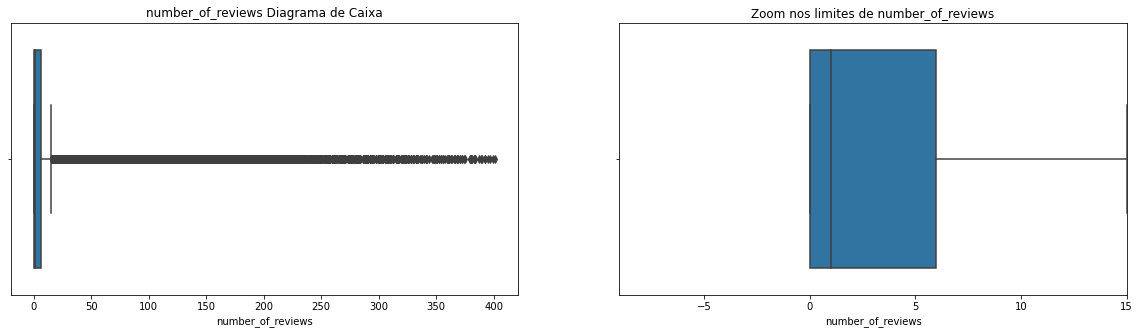

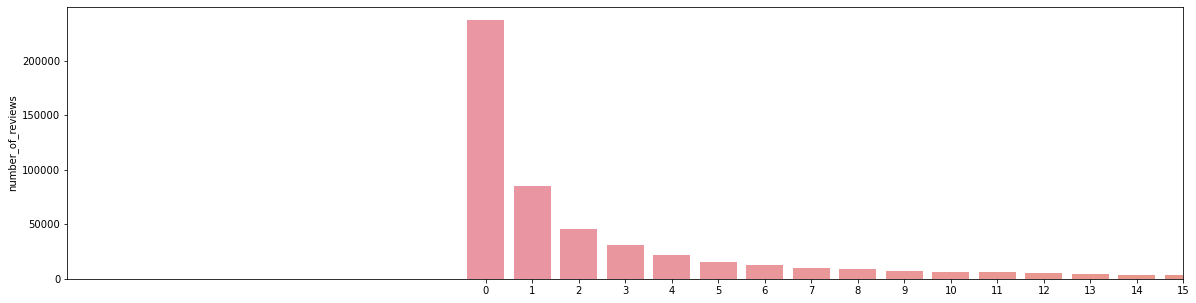

In [111]:
diagrama_caixa(base_airbnb, 'number_of_reviews')
grafico_barra(base_airbnb, 'number_of_reviews')

In [112]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)

A coluna "number_of_reviews" não irá acrescentar em nada no preço do imóvel, é um ponto positivo ter um feedback dos mesmos, porém não é impactante na hora de definir o preço de algum deles, além do fato de que ao iniciar um negócio nessa área, você não terá feedback de nenhum hóspede, pois está iniciando no negócio ainda.

### Tratamento de colunas de valores de texto

- property_type

Apartment                 462105
House                      52203
Condominium                26780
Serviced apartment         12697
Loft                       12352
Guest suite                 3621
Bed and breakfast           3605
Hostel                      2705
Guesthouse                  2234
Other                       1957
Villa                       1301
Townhouse                    976
Aparthotel                   693
Chalet                       489
Earth house                  469
Tiny house                   457
Boutique hotel               449
Hotel                        376
Casa particular (Cuba)       304
Cottage                      237
Bungalow                     232
Dorm                         186
Cabin                        149
Nature lodge                 131
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



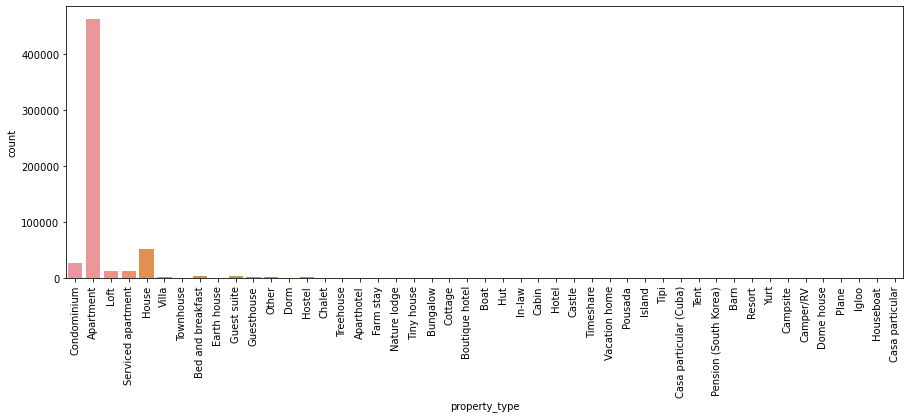

In [113]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [114]:
tabela_tipos_casas = base_airbnb['property_type'].value_counts()
colunas_agrupar = []
for tipo in tabela_tipos_casas.index:
    if tabela_tipos_casas[tipo] < 2000:
        colunas_agrupar.append(tipo)
        
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'
    
print(base_airbnb['property_type'].value_counts())

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Farm stay', 'Tent', 'Tipi', 'Barn', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Pousada', 'Houseboat', 'Timeshare', 'Casa particular', 'Plane']
Apartment             462105
House                  52203
Condominium            26780
Serviced apartment     12697
Loft                   12352
Outros                  8939
Guest suite             3621
Bed and breakfast       3605
Hostel                  2705
Guesthouse              2234
Name: property_type, dtype: int64


Como há muitas categorias e pouca frequência absoluta para a maioria, é melhor agrupar as menores frequências em uma categoria somente, até para facilitar o trabalho do modelo. Este processo será implementado em outras features que assim se comportarem também.

- room_type

Entire home/apt    376763
Private room       197094
Shared room         12409
Hotel room            975
Name: room_type, dtype: int64


c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



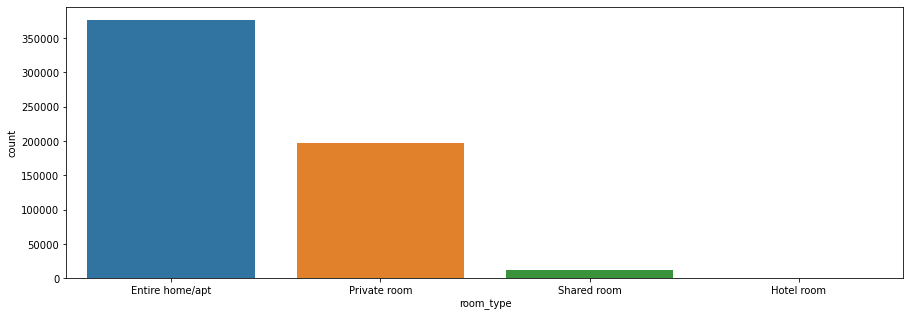

In [115]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_airbnb)
# grafico.tick_params(axis='x', rotation=90)

- bed_type

Real Bed         575888
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               509
Name: bed_type, dtype: int64


c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    575888
Outros       11353
Name: bed_type, dtype: int64


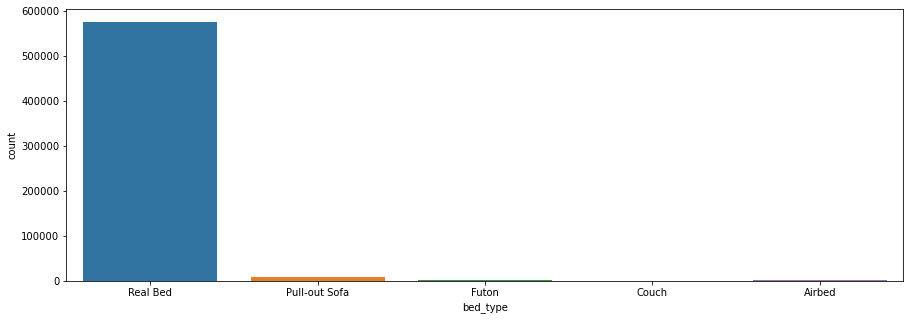

In [116]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb)

# Agrupando categorias de bed_type

tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar.clear()

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'
    
print(base_airbnb['bed_type'].value_counts())

- cancellation_policy

flexible                       259706
strict_14_with_grace_period    203388
moderate                       114155
strict                           9819
super_strict_60                   135
super_strict_30                    38
Name: cancellation_policy, dtype: int64


c:\Users\jprocha\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



['strict', 'super_strict_60', 'super_strict_30']
flexible                       259706
strict_14_with_grace_period    203388
moderate                       114155
strict                           9992
Name: cancellation_policy, dtype: int64


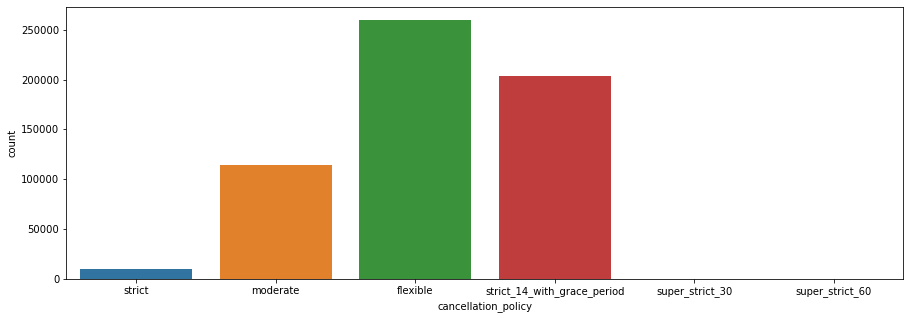

In [117]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)

# Agrupando categorias de cancellation_policy

tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar.clear()

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'
    
print(base_airbnb['cancellation_policy'].value_counts())

- amenities

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de formas diferentes, vamos avaliar a quantidade de amenities como parâmetro para o nosso modelo.

In [118]:
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[0].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [119]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(587241, 20)

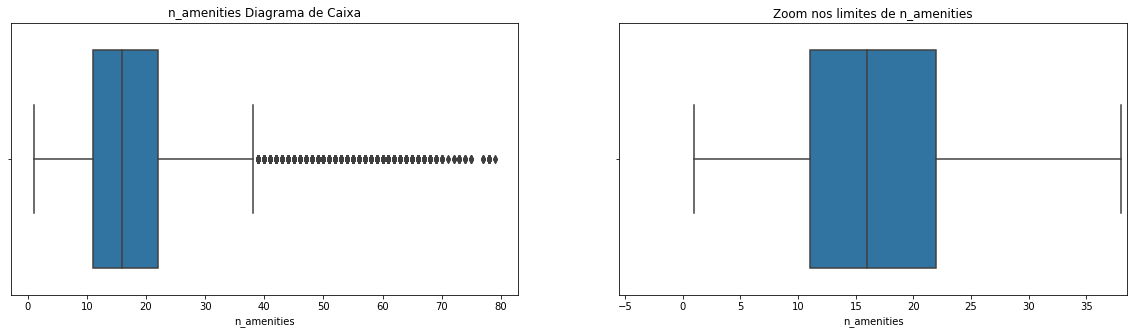

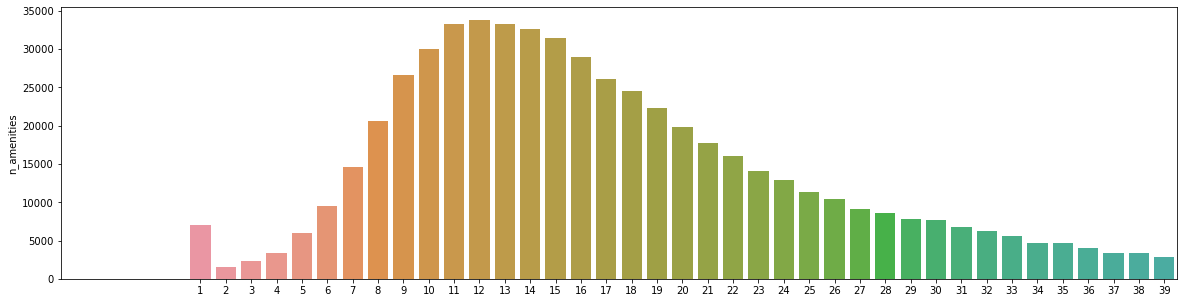

In [121]:
diagrama_caixa(base_airbnb, 'n_amenities')
grafico_barra(base_airbnb, 'n_amenities')

In [122]:
base_airbnb, qtde_linhas = excluir_outliers(base_airbnb, 'n_amenities')
print(f'{qtde_linhas:,} linhas removidas')

24,866 linhas removidas


### Visualização de Mapa das Propriedades

In [124]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', title=10*' ' + 'Densidade de Preço Diário',radius=2.5, center=centro_mapa, zoom=10, mapbox_style='stamen-terrain')

mapa.show()

### 7 - Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc)

- Features de Valores True e False, vamos substituir True por 1 e False por 0
- Features de Categoria (features em que os valores da colunas são texto) vamos utilizar o método de encoding de variáveis dummies.

In [125]:
# Dados True ou False
from sklearn.preprocessing import LabelEncoder


colunas_tf = ['host_is_superhost','instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0
    base_airbnb_cod[coluna] = base_airbnb_cod[coluna].astype(int)
    LabelEncoder()

In [48]:
# Dados categoria texto
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)

display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### 8 - Modelo de previsão

Etapas a serem realizadas para se definir um modelo de previsão:

- Definir se é Classificação ou Regressão: Classificação - Prever se algo se encaixa em uma categoria específica; Regressão - Calcular valores, exemplo, preço de alguma coisa.

- Escolher Métricas para avaliar o modelo: R² - Traça o quanto o modelo acerta; RSME(Erro quadrático Médio) - Traça o quanto o modelo erra, erros maiores resultando em um resultado mais negativo.

- Escolher quais modelos vamos usar/testar: Linear regression - Traça a melhor reta, a qual minimiza os erros; Random Forest Regressor - Modelo de árvore de decisão, semelhante ao jogo de tabuleiro Cara a Cara; Extra Trees - A mesma coisa.

- Comparar os resultados dos modelos e escolher o vencedor: 

- Analisar o melhor modelo mais a fundo

- Fazer ajustes no melhor modelo

- Métricas de Avaliação

In [49]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo: {nome_modelo} \nR²: {r2:.2%}\nRSME: {RSME:.2f}'

- Escolha dos Modelos a Serem Testados
  1. RandomForest
  2. LinearRegression
  3. Extra Tree 

In [50]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et}

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separar os dados em treino e teste + Treino do Modelo

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    # Treinar
    modelo.fit(x_train, y_train)
    # Testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(modelo, y_test, previsao))

Modelo: RandomForestRegressor() 
R²: 97.16%
RSME: 44.76
Modelo: LinearRegression() 
R²: 32.89%
RSME: 217.39
Modelo: ExtraTreesRegressor() 
R²: 97.40%
RSME: 42.77


### 9 - Análise do melhor modelo

In [52]:
for nome_modelo, modelo in modelos.items():
    # Testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(modelo, y_test, previsao))

Modelo: RandomForestRegressor() 
R²: 97.16%
RSME: 44.76
Modelo: LinearRegression() 
R²: 32.89%
RSME: 217.39
Modelo: ExtraTreesRegressor() 
R²: 97.40%
RSME: 42.77


- Modelo escolhido como melhor modelo: **ExtraTreesRegressor**

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME) 
    
    
    vamos escolher o modelo ExtraTrees.
    O modelo de regressão linear não obteve resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2.

### 10 - Ajustes e melhorias de modelo

,0
bedrooms,0.109666
latitude,0.103369
longitude,0.100428
extra_people,0.088465
n_amenities,0.087994
accommodates,0.076381
bathrooms,0.071259
room_type_Entire home/apt,0.065857
minimum_nights,0.065220
beds,0.053112


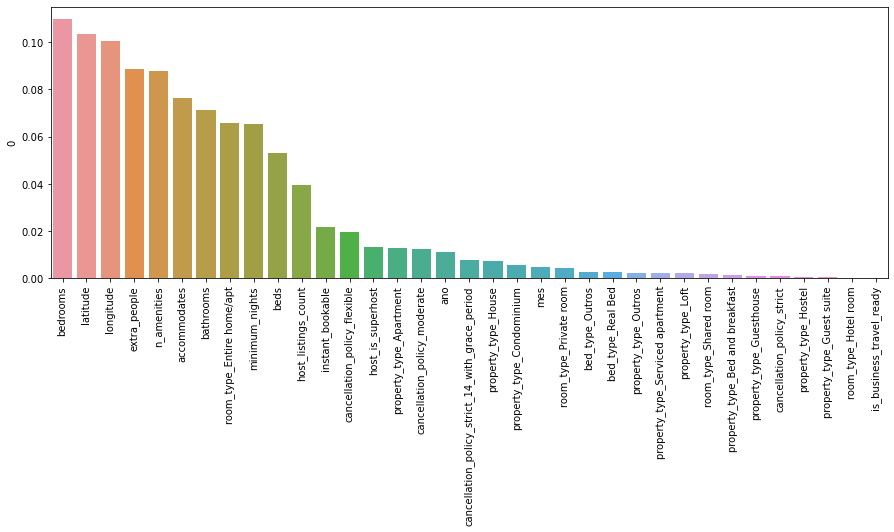

In [53]:
# print(modelo_et.feature_importances_)
# print(x_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)

display(importancia_features)

plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel_ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [54]:
base_airbnb_cod.drop('is_business_travel_ready', axis=1, inplace=True)

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

# Treinar
modelo_et.fit(x_train, y_train)
# Testar
previsao = modelo_et.predict(x_test)
print(avaliar_modelo(modelo_et, y_test, previsao))

Modelo: ExtraTreesRegressor() 
R²: 97.39%
RSME: 42.91


- A coluna bed_type também não parece relevante, visto que sua importância para o modelo é bem pequena e como só temos duas categorias nessa feature, então é positivo testar para ver se o modelo melhora com a ausência dessa feature. As colunas property_type e room_type não é interessante serem alteradas dessa forma, pois ambas possuem muitas categorias, neste caso, o ideal é agrupar mais.

In [55]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste.drop(coluna, axis=1, inplace=True)

print(base_teste.columns)
y = base_teste['price']
x = base_teste.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

# Treinar
modelo_et.fit(x_train, y_train)
# Testar
previsao = modelo_et.predict(x_test)
print(avaliar_modelo(modelo_et, y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo: ExtraTreesRegressor() 
R²: 97.39%
RSME: 42.89


In [56]:
print(previsao)

[ 52.55  80.26 120.39 ...  89.38 286.24 193.4 ]


# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)
- Passo 2 -> Escolher a forma de deploy:
  - Arquivo Executável + Tkinter
  - Deploy em um Microsite (Flask)
  - Deploy apenas para uso direto (Streamlit)
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy finalizado

In [57]:
# Salvando os dados tratados
x['price'] = y
x.to_csv('Dados.csv')

In [58]:
# Criando um arquivo que carregue o modelo
import joblib   # Esta biblioteca permite que o arquivo criado seja lido e executado por outro arquivo python
joblib.dump(modelo_et, 'Modelo.joblib')

['Modelo.joblib']